# Description

This notebook focuses on visualizing nodes within the Pywr-DRB model along with USGS gauge locations near those nodes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pltwa
import geopandas as gpd
from shapely.geometry import Point, LineString
import contextily as cx

In [49]:
### Load DRB shapefile
drb = gpd.read_file('DRB_shapefiles/drb147.shp')
drb_boarder = gpd.read_file(f'DRB_shapefiles/drb_bnd_polygon.shp')
crs = 4386
drb = drb.to_crs(crs)
drb_boarder = drb_boarder.to_crs(crs)

In [6]:
### Load nodes
nodes = pd.read_csv('../model_data/drb_model_nodes.csv', sep = ',')

### Filter 
keep_link_nodes = ['link_delLordville', 
              'link_delMontague', 
              'link_delTrenton', 
              'link_outletAssunpink', 
              'link_outletSchuylkill', 
              'link_outletChristina']

reservoir_nodes = nodes[nodes.type == 'storage']
link_nodes = nodes.loc[nodes['name'].isin(keep_link_nodes)]

# Convert to geodata
reservoir_nodes = gpd.GeoDataFrame(reservoir_nodes, geometry = gpd.points_from_xy(reservoir_nodes.lat, reservoir_nodes.long, crs = crs))
link_nodes= gpd.GeoDataFrame(link_nodes,geometry = gpd.points_from_xy(link_nodes.lat, link_nodes.long, crs = crs))

In [44]:
### Load ALL found USGS gauges
gauge_data_dir = 'C:/Users/tja73/Desktop/Research/USGS_DRB/inflow_generation/data_preprocessing'
data_fields = ['site_no', 'lat', 'long','begin_date','end_date','drain_sqkm','geometry']
gauges = pd.read_csv(f'{gauge_data_dir}/gauge_data/gauge_metadata.csv', sep = ',', names = data_fields)

In [51]:
### Filter USGS guages
def filter_drb_sites(x, site_ids = None):
    sdir = 'C:/Users/tja73/Desktop/Research/USGS_DRB/pywr/DRB_water_management/DRB_spatial/DRB_shapefiles'
    if type(x) == np.ndarray:
        x = pd.DataFrame(x)
    if site_ids is not None:
        x.index = site_ids

    crs = 4386
    drb_boarder = gpd.read_file(f'{sdir}/drb_bnd_polygon.shp')
    drb_boarder = drb_boarder.to_crs(crs)
    x_all = gpd.GeoDataFrame(x, geometry = gpd.points_from_xy(x.long, x.lat, crs = crs))
    x_filtered = gpd.clip(x_all, drb_boarder)
    return x_filtered

gauges = filter_drb_sites(gauges)
gauges = gpd.GeoDataFrame(gauges, geometry = gpd.points_from_xy(gauges.long, gauges.lat, crs = crs))
gauges.shape

(145, 7)

In [103]:
### Load Pywr-node specific gauges
node_gauges = pd.read_csv('../model_data/drb_model_usgs_data_sources.csv', sep = ',')

# Flatten the list since multiple sites listed for some nodes
node_gauge_list = []
for gs in node_gauges.USGS_gages.values:
    if type(gs) == str:
        split = gs.split(', ')
        for s in split:
            if s[0] == '0':
                s = s[1:]
            node_gauge_list.append(int(s))

In [113]:
### Filter just gauges assigned to nodes
pywr_gauges = gauges.loc[gauges['site_no'].isin(node_gauge_list)]
pywr_gauges = gpd.GeoDataFrame(pywr_gauges, geometry = gpd.points_from_xy(pywr_gauges.long, pywr_gauges.lat, crs = crs))

<AxesSubplot: >

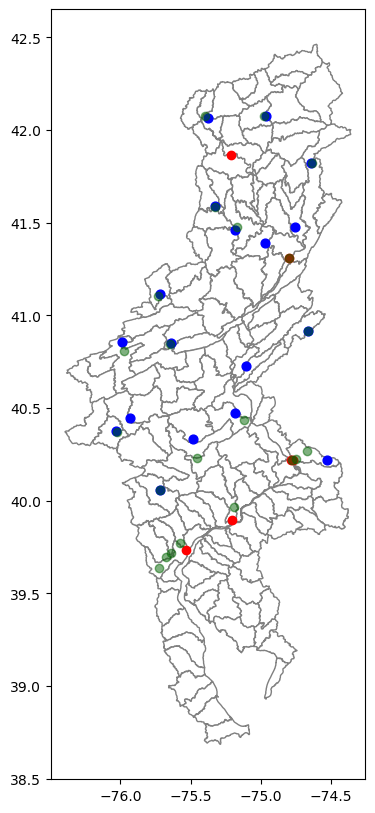

In [115]:
# Plot
ax = drb.plot(figsize=(10,10), color='w',edgecolor='0.5')
reservoir_nodes.plot(color='b', legend=True, markersize = 40, ax=ax)
link_nodes.plot(color='r', legend=True, ax=ax)
pywr_gauges.plot(color = 'darkgreen', legend = True, ax=ax, alpha = 0.5)